In [9]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import mrcnn.config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "")
print("MODEL_DIR: ", MODEL_DIR)

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "remote_sensing_cfg20240505T1512/mask_rcnn_remote_sensing_cfg_0001.h5")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "remote_sensing_mask_rcnn_trained.h5")
print("COCO_MODEL_PATH", COCO_MODEL_PATH)
# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "remote_sensing_mask_rcnn_trained_nay.h5")
print("SHAPES_MODEL_PATH", SHAPES_MODEL_PATH)

MODEL_DIR:  C:\Users\Wint3\Documents\00\ESPRIT\sem8\Deep-Learning\DL-Projet\mask-rcnn\pdl\
COCO_MODEL_PATH C:\Users\Wint3\Documents\00\ESPRIT\sem8\Deep-Learning\DL-Projet\mask-rcnn\pdl\remote_sensing_mask_rcnn_trained.h5
SHAPES_MODEL_PATH C:\Users\Wint3\Documents\00\ESPRIT\sem8\Deep-Learning\DL-Projet\mask-rcnn\pdl\remote_sensing_mask_rcnn_trained_nay.h5


In [10]:
CLASS_NAMES = [
    "BG",
    "airplane",
    "ship",
    "storage tank",
    "baseball diamond",
    "tennis court",
    "basketball court",
    "ground track field",
    "harbor",
    "bridge",
    "vehicle",
]


class PredictionConfig(mrcnn.config.Config):
    NAME = "remote_sensing_inference"
    NUM_CLASSES = len(CLASS_NAMES)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config = PredictionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Notebook Preference

In [11]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load Validation Dataset

In [16]:
import os
import xml.etree
from numpy import zeros, asarray
import imgaug

import mrcnn.utils
import mrcnn.config
import mrcnn.model


class RemoteSensingDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        # Adds information (image ID, image path, and annotation file path) about each image in a dictionary.
        self.add_class("dataset", 1, "airplane")
        self.add_class("dataset", 2, "ship")
        self.add_class("dataset", 3, "storage tank")
        self.add_class("dataset", 4, "baseball diamond")
        self.add_class("dataset", 5, "tennis court")
        self.add_class("dataset", 6, "basketball court")
        self.add_class("dataset", 7, "ground track field")
        self.add_class("dataset", 8, "harbor")
        self.add_class("dataset", 9, "bridge")
        self.add_class("dataset", 10, "vehicle")

        images_dir = dataset_dir + "/images/"
        annotations_dir = dataset_dir + "/annots/"

        for filename in os.listdir(images_dir):
            image_id = filename[:-4]

            # Split all_images: 800 * 0.7 = 560
            # Split positive_images only: 650 * 0.7 = 455
            if is_train and int(image_id) >= 456:
                continue

            if not is_train and int(image_id) < 456:
                continue

            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + ".xml"

            self.add_image(
                "dataset",
                image_id=image_id,
                path=img_path,
                annotation=ann_path,
                class_ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            )

    # Loads the binary masks for an image.
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info["annotation"]
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype="uint8")

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]

            # box[4] has the name of the class
            if box[4] == "airplane":
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index("airplane"))
            elif box[4] == "ship":
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index("ship"))
            elif box[4] == "storage tank":
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index("storage tank"))
            elif box[4] == "baseball diamond":
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index("baseball diamond"))
            elif box[4] == "tennis court":
                masks[row_s:row_e, col_s:col_e, i] = 5
                class_ids.append(self.class_names.index("tennis court"))
            elif box[4] == "basketball court":
                masks[row_s:row_e, col_s:col_e, i] = 6
                class_ids.append(self.class_names.index("basketball court"))
            elif box[4] == "ground track field":
                masks[row_s:row_e, col_s:col_e, i] = 7
                class_ids.append(self.class_names.index("ground track field"))
            elif box[4] == "harbor":
                masks[row_s:row_e, col_s:col_e, i] = 8
                class_ids.append(self.class_names.index("harbor"))
            elif box[4] == "bridge":
                masks[row_s:row_e, col_s:col_e, i] = 9
                class_ids.append(self.class_names.index("bridge"))
            elif box[4] == "vehicle":
                masks[row_s:row_e, col_s:col_e, i] = 10
                class_ids.append(self.class_names.index("vehicle"))

        return masks, asarray(class_ids, dtype="int32")

    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall(".//object"):
            name = box.find("name").text
            xmin = int(box.find("./bndbox/xmin").text)
            ymin = int(box.find("./bndbox/ymin").text)
            xmax = int(box.find("./bndbox/xmax").text)
            ymax = int(box.find("./bndbox/ymax").text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)

        width = int(root.find(".//size/width").text)
        height = int(root.find(".//size/height").text)
        return boxes, width, height

In [26]:
# Build validation dataset
dataset = RemoteSensingDataset()
# dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset.load_dataset(dataset_dir=MODEL_DIR + "/NWPU VHR-10 dataset", is_train=False)

# Must call before using the dataset
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 195
Classes: ['BG', 'airplane', 'ship', 'storage tank', 'baseball diamond', 'tennis court', 'basketball court', 'ground track field', 'harbor', 'bridge', 'vehicle']


# Load Model

In [22]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(
        mode="inference",
        config=config,
        model_dir=MODEL_DIR,
)

In [23]:
# Load weights
weights_path = COCO_MODEL_PATH
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\Wint3\Documents\00\ESPRIT\sem8\Deep-Learning\DL-Projet\mask-rcnn\pdl\remote_sensing_mask_rcnn_trained.h5


# Detect

image ID: dataset.555 (99) 
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    9.00000  max:    9.00000  int32
gt_bbox                  shape: (2, 4)                min:   46.00000  max:  972.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    9.00000  uint8


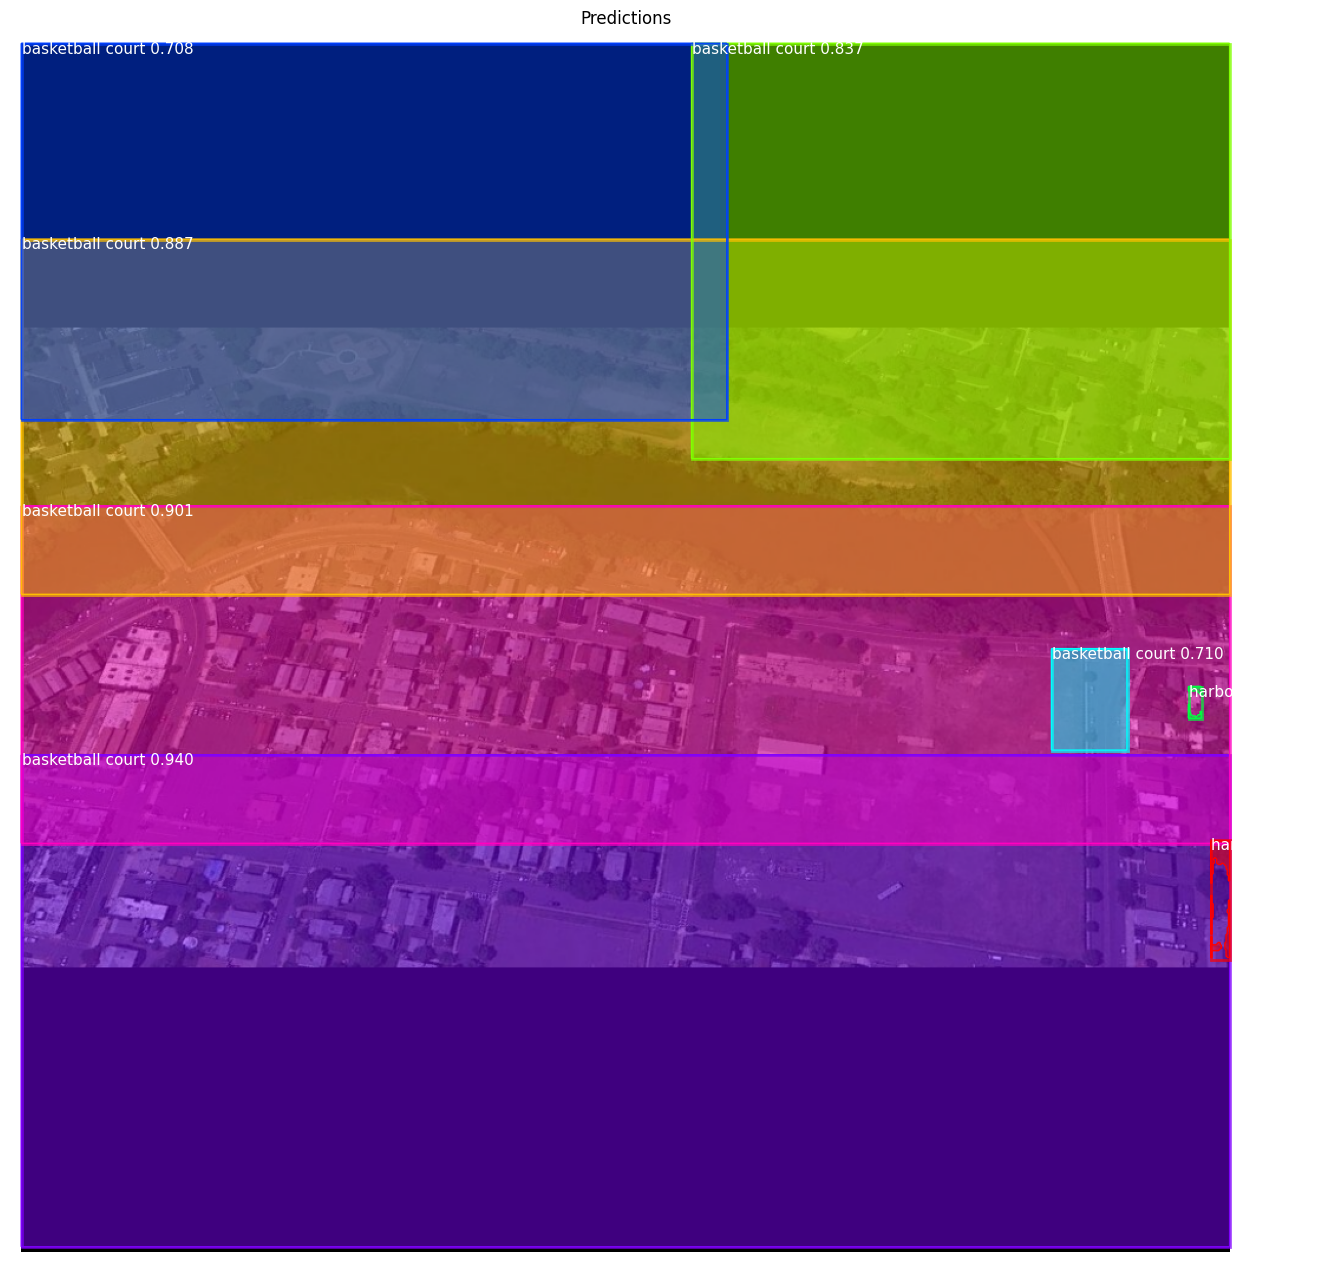

In [27]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Precision-Recall

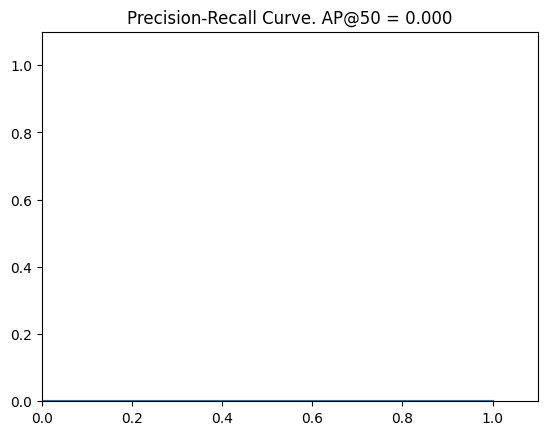

In [30]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

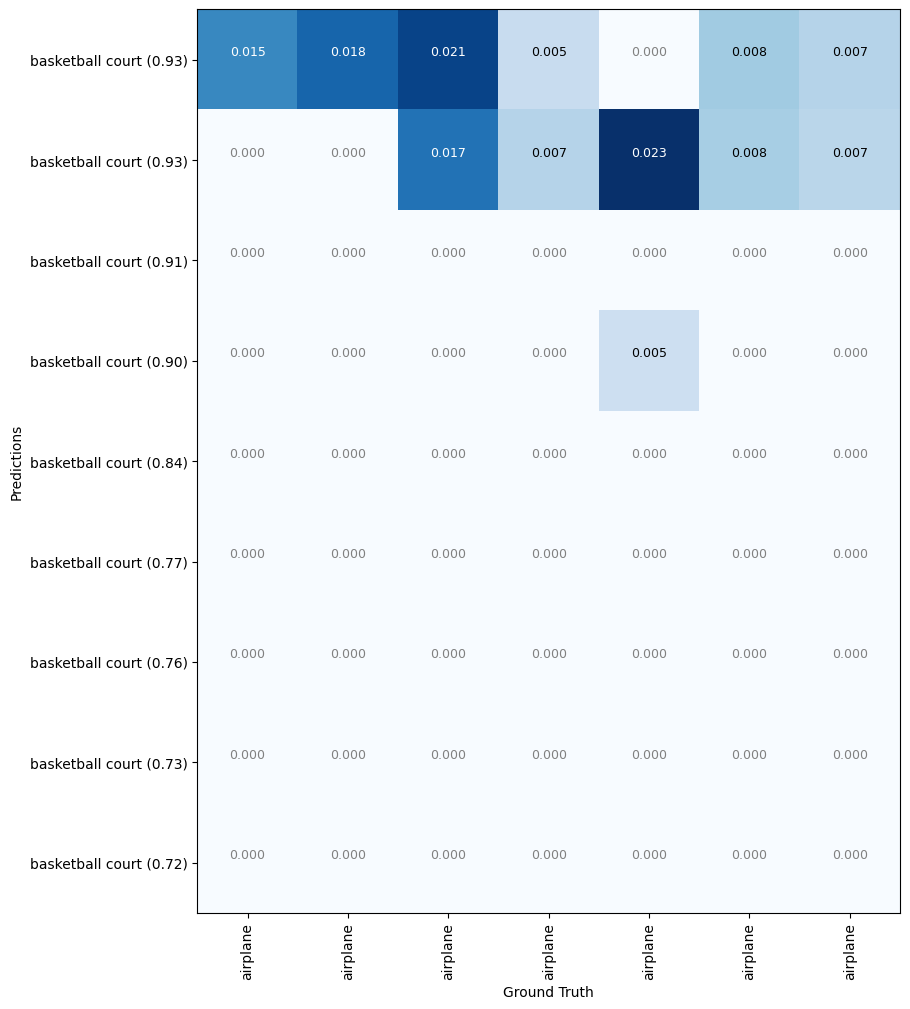

In [31]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

# Compute mAP @ IoU=50 on Batch of Images

In [ ]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

# Step by Step Prediction

Re-starting from epoch 1


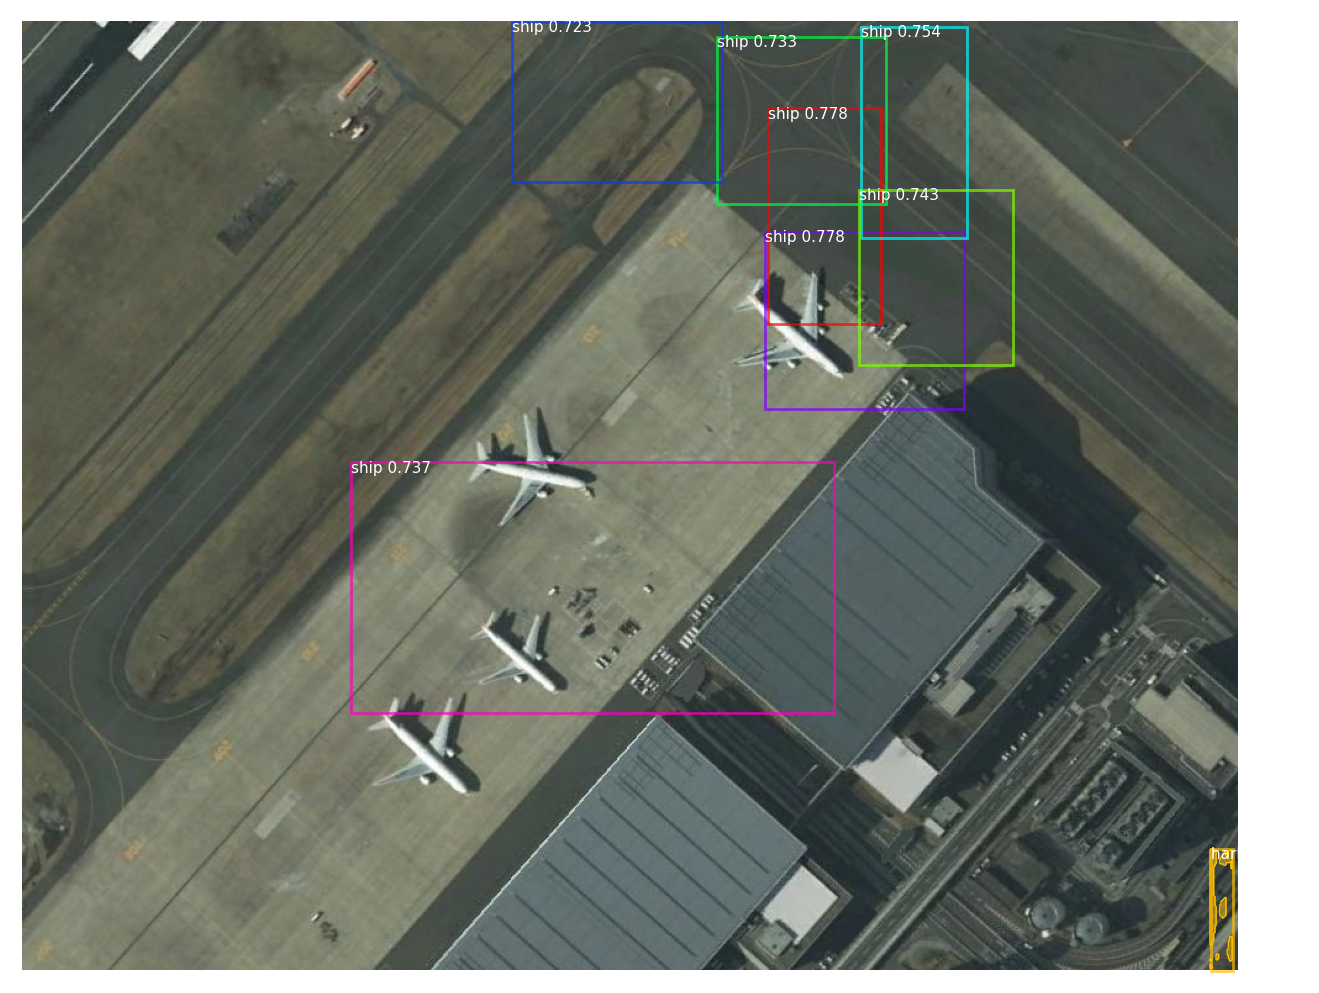

In [7]:
# import sys
# import os

# # Adjusting the path to include the parent directory
# sys.path.append("../")

# import mrcnn
# import mrcnn.config
# import mrcnn.model
# import mrcnn.visualize
# import cv2

# # Adjusting the path to locate the models
# model_path = "../remote_sensing_cfg20240505T1512/mask_rcnn_remote_sensing_cfg_0001.h5"

# # load the class label names from disk, one label per line
# # CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")
# CLASS_NAMES = [
#     "BG",
#     "airplane",
#     "ship",
#     "storage tank",
#     "baseball diamond",
#     "tennis court",
#     "basketball court",
#     "ground track field",
#     "harbor",
#     "bridge",
#     "vehicle",
# ]

# class PredictionConfig(mrcnn.config.Config):
#     # Give the configuration a recognizable name
#     NAME = "remote_sensing_inference"

#     # set the number of GPUs to use along with the number of images per GPU
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

#     # Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
#     NUM_CLASSES = len(CLASS_NAMES)

# # Initialize the Mask R-CNN model for inference and then load the weights.
# # This step builds the Keras model architecture.
# model = mrcnn.model.MaskRCNN(
#     # mode="inference", config=PredictionConfig(), model_dir=os.getcwd()
#     mode="inference",
#     config=PredictionConfig(),
#     # model_dir="./rs_model",
#     model_dir="./",
# )

# # Load the weights into the model.
# model.load_weights(filepath=model_path, by_name=True)

# # load the input image, convert it from BGR to RGB channel
# image_path = "../images_test/007.jpg"
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Perform a forward pass of the network to obtain the results
# r = model.detect([image], verbose=0)

# # Get the results for the first image.
# r = r[0]

# # Visualize the detected objects.
# mrcnn.visualize.display_instances(
#     image=image,
#     boxes=r["rois"],
#     masks=r["masks"],
#     class_ids=r["class_ids"],
#     class_names=CLASS_NAMES,
#     scores=r["scores"],
# )
